## Using the tf.data.Dataset API to work with large climate datasets and netcdf files

The [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) provides a way to build input data pipelines for machine learning projects. One of the most helpful features of the API is the ability to train on datasets that are too large to fit in memory. In this case, tensorflow can iterate over the dataset during training, reading only the data that is needed for each training step. Most of the tf.data.Dataset functions can be multi-threaded and can occur in parallel with training, so depending on the complexity of your network, this doesn't necessarily even slow down training. 

One limitation is that there are currently no built-in ways to iteratively read data from netcdf datasets. The code here shows one solution to read netcdf data using a combination of built-in features and some custom functions.

For background on the tf.data API, check out [Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data), as well as the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) documentation.

In [1]:
import numpy as np
import glob
import netCDF4
import tensorflow as tf
import matplotlib.pyplot as plt

### The data...
For this example, we want to train a neural network using global, gridded, daily data from 10 climate model simulations - specifically, we will use 10 historical simulations of the MPI-ESM1-2-LR model from the CMIP6 archive. This is more data than we can hold in memory at once, so we will need to read the data in iteratively during training. We have done some pre-processing so that each simulation is saved in one netcdf file that covers the period from 1850-2014. Each file is ~4GB. 

The input to the network will be daily z500 maps, and the output from the network will be daily surface temperature for one grid point over Europe. (For simplicity, we won't use any time lag between the input and the output). 

In [2]:
file_directory = "./CMIP6_data/"
sorted(glob.glob(file_directory+"z500*.nc"))

['./CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r10i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r1i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r2i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r3i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r4i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r5i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r6i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r7i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r8i1p1f1_18500101_20141231_2x2.nc',
 './CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_r9i1p1f1_18500101_20141231_2x2.nc']

In [3]:
## latitudes and logitudes for location over France where we will predict temperatures
ilat = 72 ## index of latitude, corresponds to 45.7 deg N
ilon = 3 ## index of longitude, corresponds to 5.6 deg E

### Overview

This notebook uses the following general approach to read data directly from the original netcdf files: 
1. We first create a tf.data.dataset based on "metadata" that corresponds to individual input/output samples. In this case, each sample can be identified by the date and the simulation from which it comes (explained in more detail below).
2. We then define a function that will take that metadata information as input and load the corresponding input/output samples at training time. We can apply this function to our dataset by using the map() function within the tf.data API 
3. We can then pass our dataset directly to model.fit() in order to train our neural network. 

### Step 1a: define the metadata to identify each input sample
For this example, each sample in our data can be identified by two pieces of information: the date and the simulation. (Because each simulation uses the same dates, we can also identify dates based on the index along the time dimension of each file - this is actually what we will use later on to simplify the file subsetting).

We want our dataset to include all date and simulation combinations. We want the dates for each batch to be random (not consecutive). Another choice we will make is to draw samples from a single simulation per batch. This means we only need to open one file per batch, which should speed up data reading quite a bit. The permute_shuffle_batch() function below takes our dates and simulations as input, and returns two np.arrays of all possible date-simulation combinations. It is also set up so that every N elements in the array correspond to the same simulations, where N is our batch size.  


In [4]:
dates = np.arange(np.datetime64("1850-01-01T12:00:00.000000000"), 
                  np.datetime64("2014-12-10T12:00:00.000000000"), # account for 21-day prediction lead
                  step = np.timedelta64(1,'D')) 
dates_index = np.arange(len(dates)) 
dates

array(['1850-01-01T12:00:00.000000000', '1850-01-02T12:00:00.000000000',
       '1850-01-03T12:00:00.000000000', ...,
       '2014-12-07T12:00:00.000000000', '2014-12-08T12:00:00.000000000',
       '2014-12-09T12:00:00.000000000'], dtype='datetime64[ns]')

In [5]:
train_simulations = np.array(["r"+str(i)+"i1p1f1" for i in range(1, 11)])
train_simulations

array(['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1',
       'r6i1p1f1', 'r7i1p1f1', 'r8i1p1f1', 'r9i1p1f1', 'r10i1p1f1'],
      dtype='<U9')

In [6]:
batch_size = 32

In [7]:
def permute_shuffle_batch(dates, simulations, batch_size, seed = 123): 
    """this function will create two new arrays that include every permutation of 
       dates and simulations AND where the simulation is constant for each batch. 
       If len(dates) is not an exact multiple of batch_size, some dates will be 
       reused to fill last batch """
    
    np.random.seed(seed)
    
    n = len(dates)
    r = batch_size - (n % batch_size) #remainder to fill at end
    n2 = len(simulations)
    n_batch = (n+r)//batch_size
    
    shuffled_dates = []
    for i in range(n2): 
        tmp = dates
        np.random.shuffle(tmp)
        shuffled_dates.append(np.append(tmp, np.random.choice(tmp, r)))
        
    shuffled_dates = np.concatenate(shuffled_dates, axis = 0).reshape(((n+r)*n2), order = 'F')
    shuffled_simulations = np.tile(simulations.repeat(batch_size), n_batch)
    
    return shuffled_dates, shuffled_simulations

In [8]:
xy_dates, xy_simulations = permute_shuffle_batch(dates_index, train_simulations, batch_size)

print(xy_dates.shape, xy_simulations.shape)

(602560,) (602560,)


### Step 1b: Create initial tf dataset from the metadata
We can create the input dataset using the tf.data.Dataset.from_tensor_slices() function, which creates a dataset from objects in memory. We will create separate x (input) and y (output) datasets that we will then zip together at the end. 
Once we make a dataset, it is good to inspect individual elements of the dataset to make sure everything looks as expected. 

In [9]:
x_ds = tf.data.Dataset.from_tensor_slices((xy_dates, xy_simulations))
y_ds = tf.data.Dataset.from_tensor_slices((xy_dates, xy_simulations))

2022-12-05 19:54:10.903213: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
x_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.int64, tf.string)>

In [11]:
for elem in x_ds.take(4).as_numpy_iterator():
    print(elem)

(31750, b'r1i1p1f1')
(59137, b'r1i1p1f1')
(55281, b'r1i1p1f1')
(58925, b'r1i1p1f1')


For our pipeline, we want to batch the dataset before mapping it to the actual data in the next step. This allows us to apply the mapping function to an entire batch at once. After batching, we will also shuffle the dataset and specify reshuffle_each_iteration=True. This ensures that each epoch of training sees the batches in a different order. For other specifics on shuffling, see [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

If we print out one dataset element now, we can see it contains an entire batch of data. 

In [12]:
x_ds = x_ds.batch(batch_size).shuffle(buffer_size = int(len(xy_dates)/batch_size), reshuffle_each_iteration=True)
y_ds = y_ds.batch(batch_size).shuffle(buffer_size = int(len(xy_dates)/batch_size), reshuffle_each_iteration=True)

In [13]:
for elem in x_ds.take(1).as_numpy_iterator():
    print(elem)

(array([48580, 58817, 35673, 57373, 48755, 35427, 45562, 45994, 29582,
       34092, 13842, 25714, 37114, 53093,   466, 35694, 12267, 14892,
       33943,  9485, 24509, 59185, 11652, 38102, 57550, 45140, 20125,
       19817, 12940, 25351, 29364, 24398]), array([b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1',
       b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1',
       b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1',
       b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1',
       b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1',
       b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1', b'r1i1p1f1',
       b'r1i1p1f1', b'r1i1p1f1'], dtype=object))


### Step 2: map the dataset to the actual data

The next step in our pipeline is to define functions to load the actual data for each batch. We will have one function that loads our input data (get_x_data()) and one function that loads our output labels (get_y_data()). The functions must take a dataset element as input. Because we batched the dataset in the last stap, each dataset element is one batch of samples containing date and simulation information.

We will then use dataset.map() to apply this function to the current dataset. Because our get_x_data() and get_y_data() functions contain some non-tensorflow code (for example, functions from the netCDF4 package), we need to use the tf.py_function syntax. Once we have mapped the dataset, we can again inspect the first elements to make sure everything looks as expected. 

Note: dataset.map() has a num_parallel_calls option that we can use to execute computations in parallel. However, from the tensorflow documentation: "note that the use of tf.numpy_function and tf.py_function in general precludes the possibility of executing user-defined transformations in parallel (because of Python GIL)." My advice is to try different things and see how the performance compares. This [guide](https://www.tensorflow.org/guide/data_performance) is also helpful for optimizing dataset performance. 

In [14]:
def get_x_data(dates, simulation): 
    """Read input data for each batch using the netcdf package
       For simplicity, the file paths have been hard coded here 
       This will read data for each predictor and combine into one 3-D tensor"""

    simulation = simulation[0] # all simulations are the same for each batch based on how we've set it up
    
    filename = "./CMIP6_data/z500_daily_MPI-ESM1-2-LR_historical_" + simulation.numpy().decode() + "_18500101_20141231_2x2.nc"
    
    ## read file
    ds = netCDF4.Dataset(filename)   
    
    ## select dates for this batch and convert to tensor
    dat = tf.convert_to_tensor(ds.variables["zg"][dates])
        
    return(dat)

In [15]:
def get_y_data(dates, simulation):
    simulation = simulation[0]
    filename = "./CMIP6_data/tas_daily_MPI-ESM1-2-LR_historical_" + simulation.numpy().decode() + "_18500101_20141231_2x2.nc"
    ds = netCDF4.Dataset(filename) 
    return(tf.convert_to_tensor(ds.variables["tas"][dates, ilat, ilon]))

In [16]:
x_ds = x_ds.map(lambda dates, simulation: tf.py_function(get_x_data, 
                                                         [dates, simulation], 
                                                         Tout=tf.float32))

y_ds = y_ds.map(lambda dates, simulation: tf.py_function(get_y_data, 
                                                         [dates, simulation],
                                                         Tout=tf.float32))

In [17]:
x_ds

<MapDataset shapes: <unknown>, types: tf.float32>

In [18]:
batch1_x = next(x_ds.as_numpy_iterator()) ## get first batch

In [19]:
batch1_x.shape ## we see that there are 32 samples in the batch, which each have a 90x180 input map of z500

(32, 90, 180)

In [20]:
%%time
## we can print out the actual values, and time how long it takes to actually generate this batch of data...its on the order of a few microseconds, so not too long
batch1_x

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


array([[[4843.3457, 4843.279 , 4843.261 , ..., 4843.466 , 4843.4365,
         4843.381 ],
        [4853.866 , 4853.7153, 4853.6406, ..., 4854.579 , 4854.392 ,
         4854.157 ],
        [4869.806 , 4868.839 , 4867.7827, ..., 4871.9126, 4871.3374,
         4870.6333],
        ...,
        [5291.737 , 5291.569 , 5291.462 , ..., 5292.309 , 5292.1377,
         5291.9375],
        [5237.4287, 5237.8535, 5238.2964, ..., 5235.959 , 5236.479 ,
         5236.9673],
        [5194.5547, 5195.0684, 5195.5527, ..., 5193.028 , 5193.536 ,
         5194.0527]],

       [[5253.822 , 5253.4614, 5253.14  , ..., 5254.7964, 5254.4814,
         5254.1484],
        [5265.0107, 5264.7266, 5264.4346, ..., 5265.9487, 5265.609 ,
         5265.3076],
        [5268.7363, 5269.5073, 5270.387 , ..., 5266.986 , 5267.4526,
         5268.046 ],
        ...,
        [5144.059 , 5144.014 , 5143.7617, ..., 5142.5024, 5143.3193,
         5143.84  ],
        [5135.195 , 5135.351 , 5135.4404, ..., 5134.1357, 5134.5967,
   

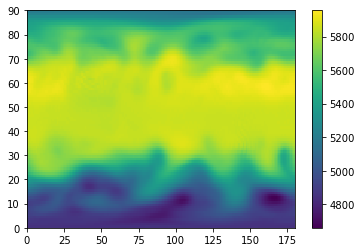

In [21]:
## plot the first sample
plt.pcolormesh(batch1_x[0])
plt.colorbar()

This definitely looks like a map of geopotential height! 

In [22]:
## check the y dataset...
batch1_y = next(y_ds.as_numpy_iterator())

In [23]:
batch1_y.shape ## here, we can see that there are again 32 samples in the first batch

(32,)

In [24]:
%%time
batch1_y

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 8.11 µs


array([277.4715 , 284.3837 , 280.17932, 287.73257, 281.0763 , 277.7764 ,
       288.33063, 278.89493, 277.72345, 283.81067, 279.27936, 285.5353 ,
       289.6241 , 284.60065, 283.98346, 288.34427, 281.4951 , 290.8068 ,
       277.19635, 290.10953, 277.43634, 281.64877, 281.3803 , 287.21753,
       289.9727 , 279.0876 , 273.4858 , 281.19653, 276.1486 , 290.24368,
       282.28134, 286.01794], dtype=float32)

These look like surface temperature values!

### Step 3: Train the neural network!

Our last step is to train our neural network. We will define a simple ANN, and pass the dataset to the model during the model.fit() step. First, we will combine our x and y datasets by zipping them together. 

In [25]:
ds = tf.data.Dataset.zip((x_ds, y_ds))
ds

<ZipDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

In [26]:
def build_model():
    input_layer = tf.keras.layers.Input(shape=(90, 180), name = "input") 
    layers = tf.keras.layers.Flatten()(input_layer)
    layers = tf.keras.layers.Dense(32, activation = 'relu')(layers)
    layers = tf.keras.layers.Dense(32, activation = 'relu')(layers)
    output_layer = tf.keras.layers.Dense(1, activation = "linear")(layers)
    
    model = tf.keras.models.Model(input_layer, output_layer)
    return(model)

In [27]:
model = build_model()
model.compile(loss="mse", 
            optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001))

In [28]:
model.fit(ds, epochs = 2, verbose = 1)

Epoch 1/2
18830/18830 [==============================] - 650s 34ms/step - loss: 16337.0010
Epoch 2/2
18830/18830 [==============================] - 642s 34ms/step - loss: 1861.1987


### Some additional notes: 
Although the tf.data API makes it easy to load data during training, constantly reading data can be slow and for some cases, it will become a bottleneck in the training process. With the amount of data in the example above, it takes over 20 minutes to train just two epochs on my desktop mac! If you are looking to speed up training, this tutorial is a very helpful place to start: [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

This was a very basic example to illustrate how you can train tensorflow models directly from large, netcdf datasets. In reality, we might make a number of different choices in setting up our problem. For example, we would likely want to standardize or pre-process our input data, which we could do by including a pre-processing step within our get_x_data() function, or by adding a normalization layer to our tensorflow model. We could also repeat the process above to create validation datasets that could be used during training for early stopping. 